# MATH80629

## Semaine #13 - Prise de décision séquentielle II (RL) - Exercices & Solutions

#### Monte Carlo prediction & control solutions

auteur: massimo.p.caccia@gmail.com <br>

Le code a été adapté à partir de&nbsp;: https://github.com/dennybritz/reinforcement-learning/tree/master/MC

Il y a deux exercices aujourd'hui. Dans le premier nous explorons la prédiction Monte-Carlo et dans le second le contrôle. 

## 1. Monte Carlo Prediction

Nous commençons par explorer **l'algorithme de Monte Carlo prediction**. <br>

L'algorithme est à la [diapo 13](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_rl2.pdf) du cours. <br>

Nous allons tester l'algorithme sur le jeu du Blackjack (diapos en plus #32). L'idée est que nous allons utiliser un agent de RL pour jouer à ce jeu. L'agent va donc apprendre une politique pour jouer au Blackjack. 

L'agent va jouer contre un adversaire  virtuel. Dans le jeu de Blackjack on nomme l'adversaire *la banque*. L'adversaire aura une politique fixe.<br>

### 1.1 Contexte

In [1]:
!pip install gym
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plottingfr.py

In [2]:
# imports
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict


from blackjack import BlackjackEnv
import plottingfr as plotting

matplotlib.style.use('ggplot')

Il est utile de revoir les règles du jeu et le déroulement de la partie (cette information est aussi disponible sur la diapo 32 et les règles sont adaptées librement de [Wikipedia](https://fr.wikipedia.org/wiki/Blackjack_(jeu))). 

**Règle du jeu :**
<ul>
<li /> La partie oppose un joueur contre la banque. Le but est de battre le croupier sans que la somme des cartes du joueur dépasse le score de 21. Si le joueur fait plus que 21, on dit qu'il « brûle » et il perd. Les valeurs des cartes sont les suivantes:
<ul>
    <li />de 2 à 9 : valeur nominale de la carte ;
    <li />de 10 au roi (surnommées « bûche »)  : 10 points ;
    <li />As : 1 ou 11 points (au choix du joueur).
</ul>
</ul>

**Déroulement de la partie (avec un joueur et la banque):** 
<ol>
<li /> Au début de la partie, la banque (le croupier) distribue une carte face visible au joueur et une carte face visible pour elle. La banque tire ensuite une seconde carte face visible et une seconde carte face cachée pour elle.
<li /> Ensuite le joueur peut demander autant de cartes qu'il le désire, une à la fois (action 1 hit) jusqu'à ce qu'il décide d'arrêter (action 0 stick). 
<li /> Finalement, la banque peut demander autant de carte qu'elle le désire (voir politique de la banque).
<li /> Si le score du joueur est plus élevé que celui de la banque et sous 21, le joueur gagne. Si son score est le même que la banque, c'est une partie nulle. Dans les autres cas, la banque gagne.
</ol>

**Informations propres au RL :**    
   
- Dans l'exemple que nous utiliserons, la banque a une politique fixe qui est de toujours demander une autre carte tant que leur score n'est pas au-dessus de 17.
- **Les récompenses:** Le joueur obtient une récompense de +1 pour une victoire, 0 pour une partie nulle et -1 pour une défaite.
- **Les états:** L'état est un vecteur de trois dimensions: 
    - le score du joueur (chiffre entre 3 et 21)
    - le score de la carte de la banque (chiffre en 1 et 11)
    - le joueur a-t-il un As qui peut valoir 1 ou 11 (binaire oui ou non)
- **Les actions:** Il y en a deux hit, stay. 
- Chaque partie de Blackjack est un épisode.
- (On imagine que le paquet de cartes est de taille infinie, ou que l'on tire les cartes avec remplacement, pour s'assurer de la stationarité des probabilités de transitions.)


<!-- <img src="blackjack.png" width="500"> --> 

In [3]:
env = BlackjackEnv()

### 1.2 Implémentation Monte Carlo Prediction

La prédiction Monte Carlo est une technique pour **évaluer une politique ($\pi$) donnée**. C'est-à-dire pour obtenir la fonction de valeur de cette politique: $V^\pi(s)\;\;\forall s \in S$.

Cette technique est un peu similaire à l'étape de *policy evaluation* dans l'algorithme *Policy Iteration* pour les MDPs. La grande différence est que (cette semaine) **nous ne connaissons pas les probabilités de transition.** 
Donc l'agent va devoir `essayer` (ou exécutez) la politique dans l'environnement. Petit à petit, épisode par épisode, nous allons obtenir des estimés de meilleur en meilleur de la valeur de la politique. 

(C'est d'ailleurs l'idée générale des approches Monte-Carlo, on approxime avec des 
échantillons.)

**L'intuition :**
L'intuition est la suivante. Imaginez qu'un ami a une stratégie (politique) pour jouer au Blackjack. Pour tester l'idée, vous pourriez aller l'essayer au casino. Vous joueriez donc un grand nombre de parties avec cette stratégie. À la fin, vous auriez donc évalué la qualité de la stratégie (sa fonction de valeur). Par exemple, si vous avez gagné de l'argent la stratégie est bonne, sinon la stratégie elle ne l'est pas. 

Le code dans la cellule d'en bas reproduit la diapo 13. <br>


In [4]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, plot_every=False):
    """
    L'algorithme Monte Carlo Prediction. L'algorithme calcule la fonction de 
    valeur d'une politique en utilisant des échantillons (épisodes). 
    
    Args:
        policy (politique): Une fonction qui donne une distribution sur les actions 
                            pour chaque état.
        env: Un environnement OpenAI gym.
        num_episodes: Le nombre d'épisodes (échantillons).
        discount_factor: Le facteur d'actualisation Gamma.
    
    Returns:
        Un dictionnaire qui contient une valeur pour chaque état (clé).
    """

    # Pour garder les récompenses ainsi que le nombre 
    # de fois que l'agent a visité chaque état.
    # On pourra utiliser cette information pour obtenir la moyenne
    # moyenne = returns_sum / returns_count
    # (note technique: on utilise un dictionnaire, on aurait
    # aussi pu utiliser un vecteur pour conserver ces informations.)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # La fonction de valeur
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        
        # On affiche le numéro de l'épisode
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # On génère un épisode.
        # Un épisode est un vecteur de tuples (state, action, reward)
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Pour chaque état visité, on met à jour sa fonction de valeur
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # On trouve la première visite à l'état dans l'épisode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # On cacule la somme des toutes les récompenses depuis 
            G = sum([x[2]*(discount_factor**i) 
                     for i,x in enumerate(episode[first_occurence_idx:])])

            # On mets à jour la fonction de valeur (tous les épisodes)
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
            
        if plot_every and i_episode % plot_every ==0:
            plotting.plot_value_function(V, title=f"{i_episode} Steps")

    return V    

Pour essayer l'algorithme d'en haut, il nous faut une politique.

Nous utiliserons une politique simple:
- L'agent demande toujours une autre carte (action *hit*) jusqu'à ce que le score soit de 20 ou 21.


In [5]:
def sample_policy(state):
    """
    La politique pose l'action 'sticks' si le score est >= 20. Sinon elle prend
    une autre carte (hit).
    """
    score, dealer_score, usable_ace = state
    return 0 if score >= 20 else 1

Nous utilisons maintenant l'algorithme *Monte-Carlo prediction* pour évaluer cette politique (la politique de la fonction `sample_policy`).

Nous utiliserons 100K épisodes (échantillons) avec l'option suivante : `num_episodes=100000`.

La figure ci-dessous montre la fonction de valeur (axe vertical) en fonction de l'état (deux axes horizontaux). 

(c'est d'ailleurs une reproduction de la figure à la diapo 16). 

Episode 100000/100000.

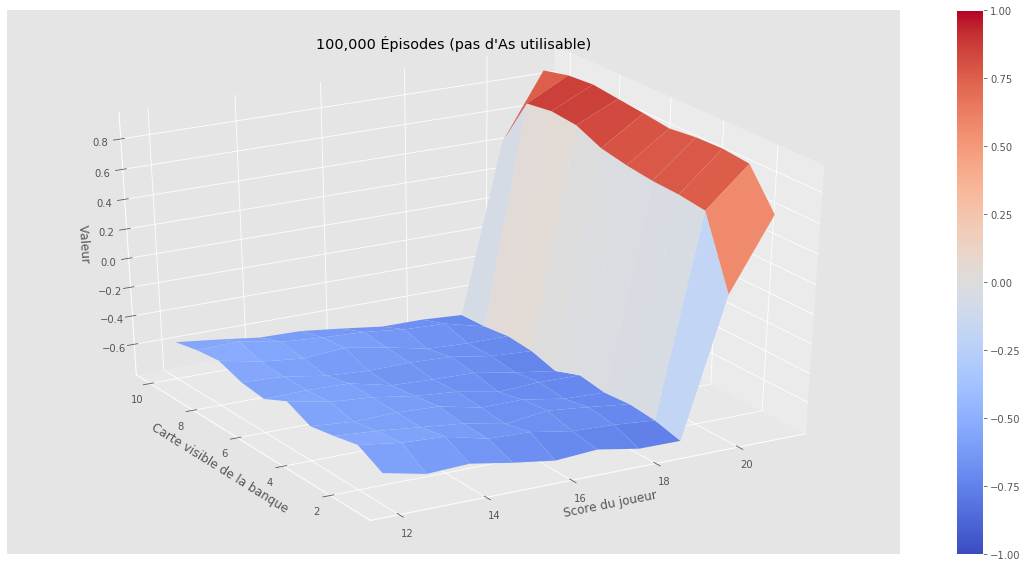

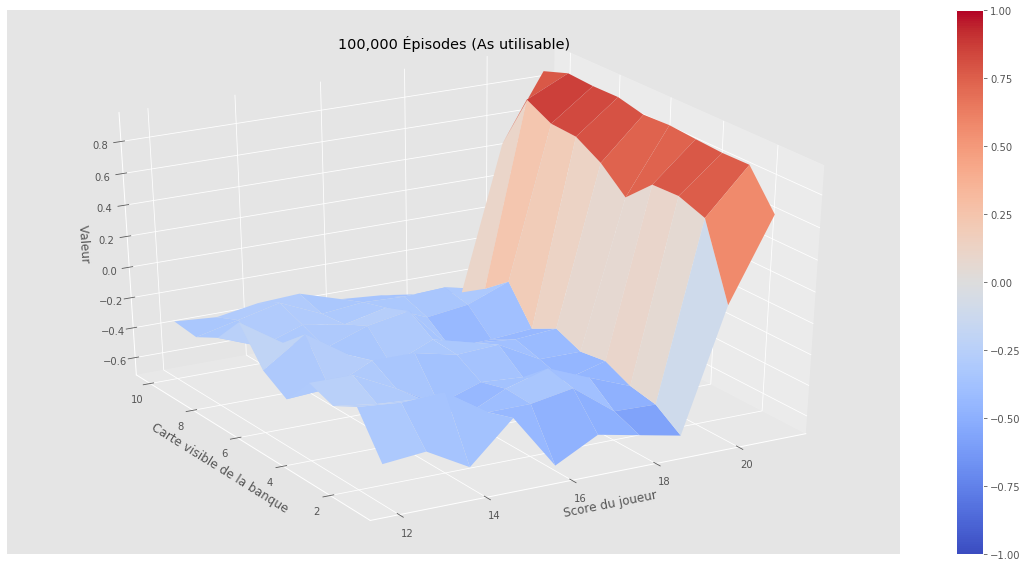

In [6]:
V_100k = mc_prediction(sample_policy, env, num_episodes=100000)
plotting.plot_value_function(V_100k, title="100,000 Épisodes")

**Question :** Pouvez-vous expliquer ces résultats?

**Réponse :**
- Rappel: une valeur de 1.0 sur l'axe vertical voudrait dire que le joueur gagne tout le temps, un -1.0 voudrait dire qu'il perd tout le temps.  
- La fonction de valeur est élevée (elle s'approche de 1.0) quand le score du joueur est de 20 ou 21. Ce résultat reflète le jeu, plus vous approchez de 21 et plus la chance de gagner est élevée. Ce résultat reflète aussi la politique simple qui *hit* jusqu'à un score de 20. En fonction de ces résultats (récompenses plus basses quand le score <=19) on peut se demander si c'est une si bonne stratégie.
- Quand la carte visible de la banque est un As (valeur 1 à droite) ou un dix (valeur 10 à gauche), on remarque aussi que la valeur diminue même si le joueur a un score de 20 ou 21. Ce sont sans doute des situations où la banque a un très bon jeu (se retrouve souvent avec 21) et donc le joueur gagne moins souvent.

### 1.3 Excercice Monte Carlo prediction 

**Question :** Quel est l'effet du nombre d'épisodes (`num_episodes`) sur la fonction de valeur?

Réfléchissez-y avant de lancer le code!

Episode 20000/200000.

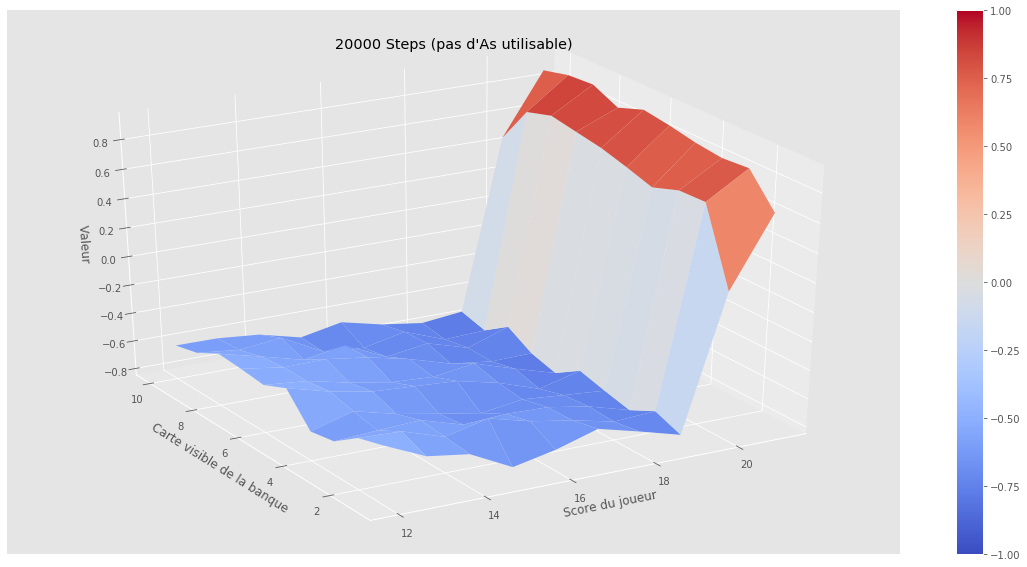

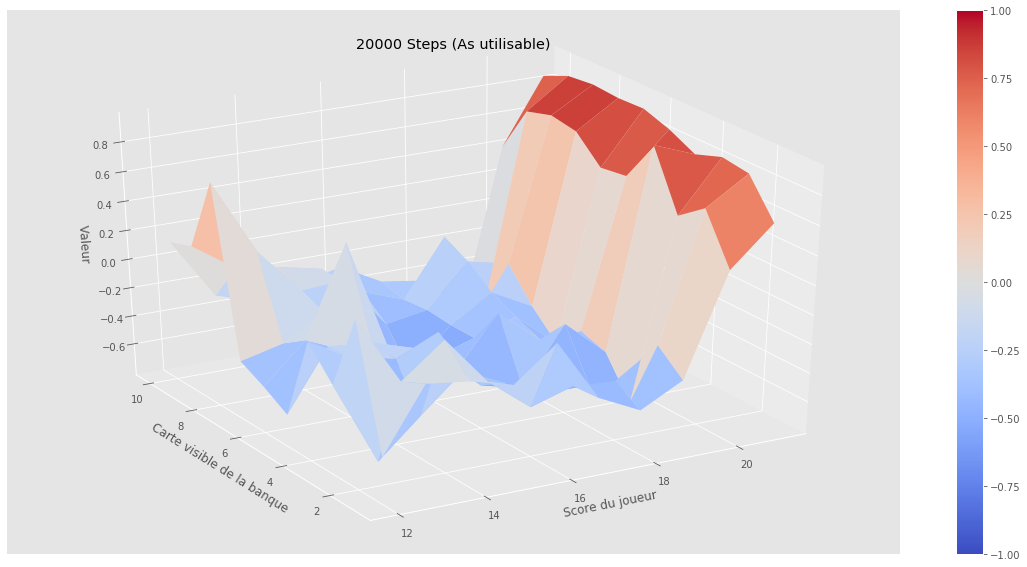

Episode 40000/200000.

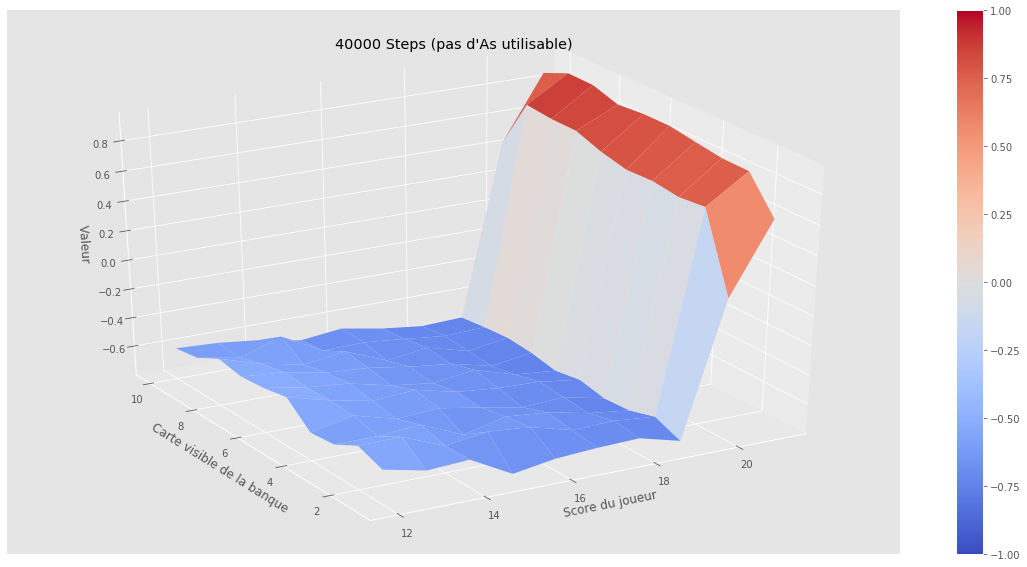

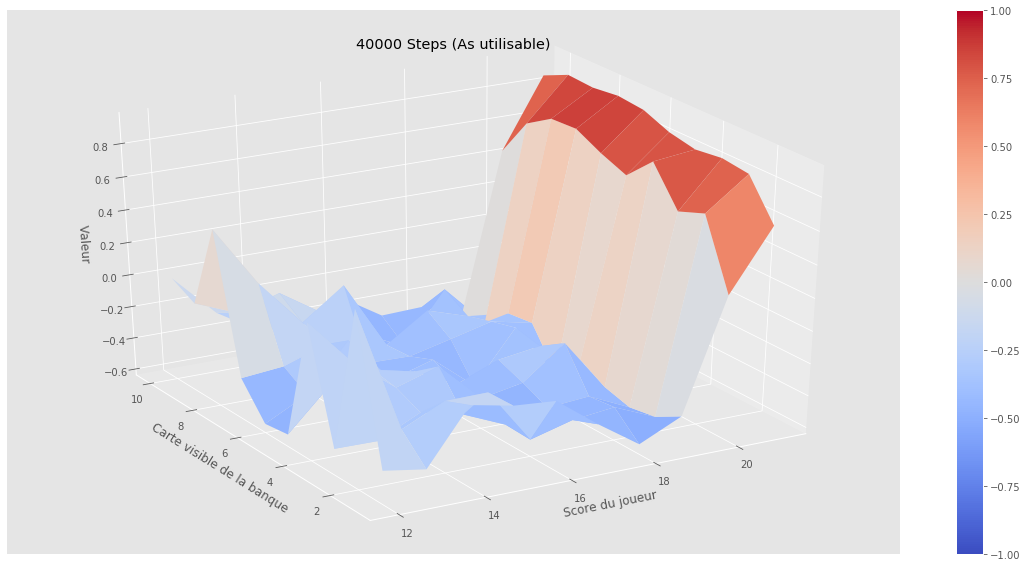

Episode 60000/200000.

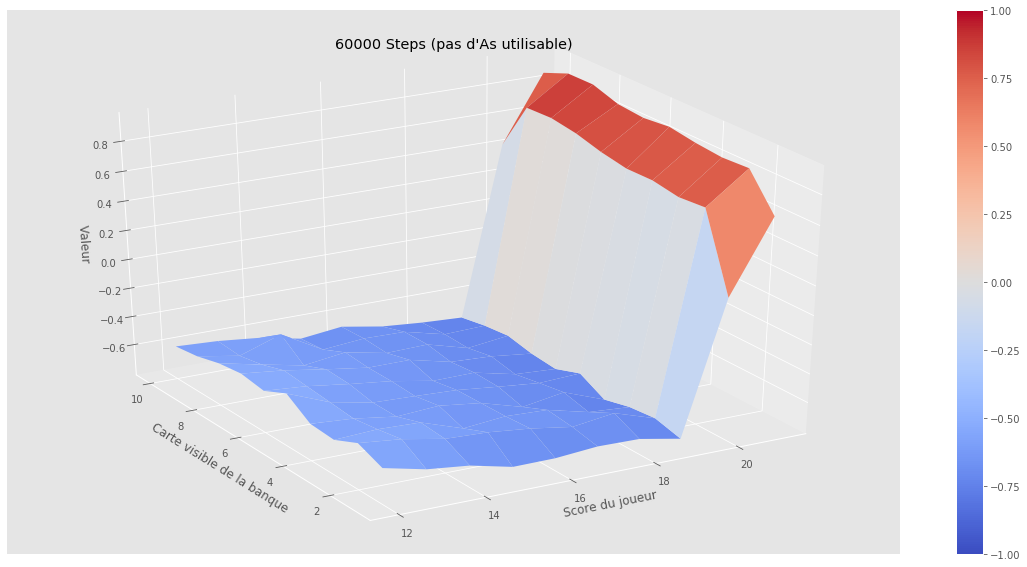

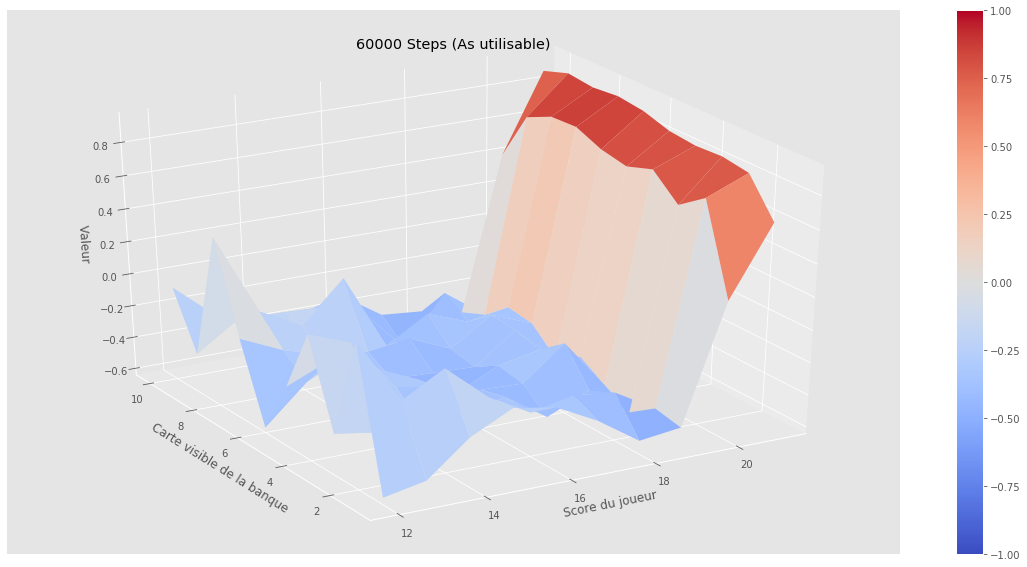

Episode 80000/200000.

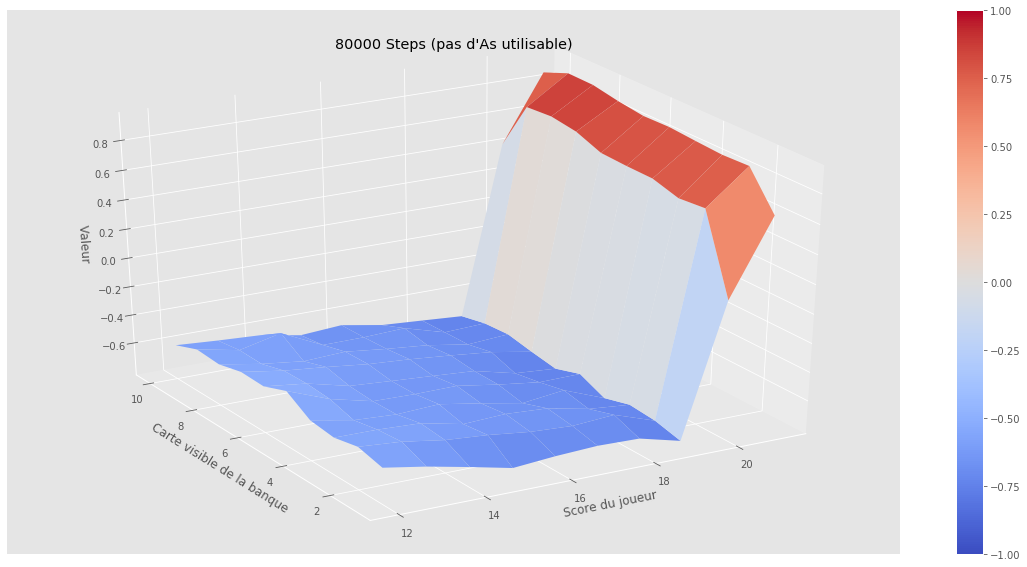

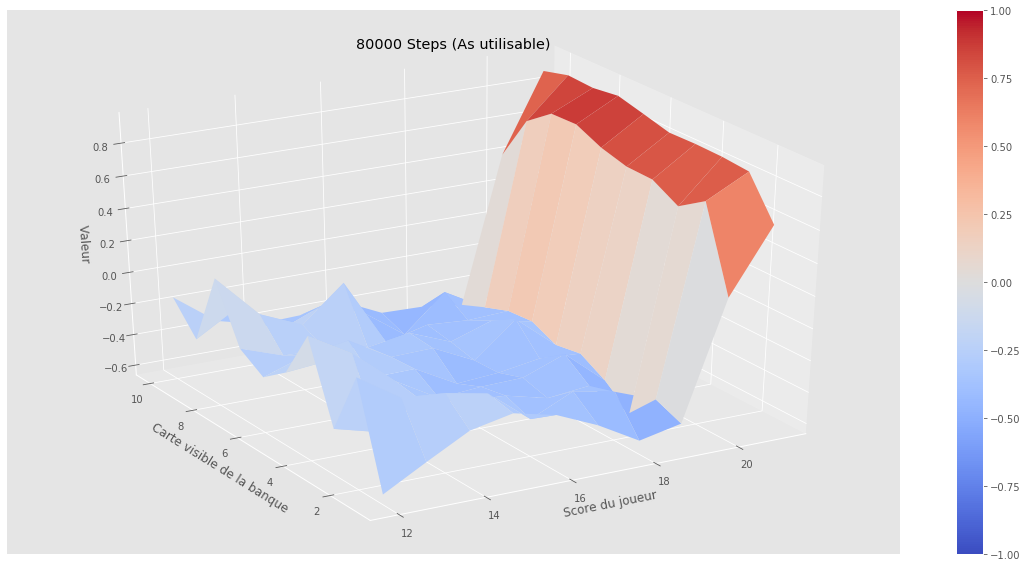

Episode 100000/200000.

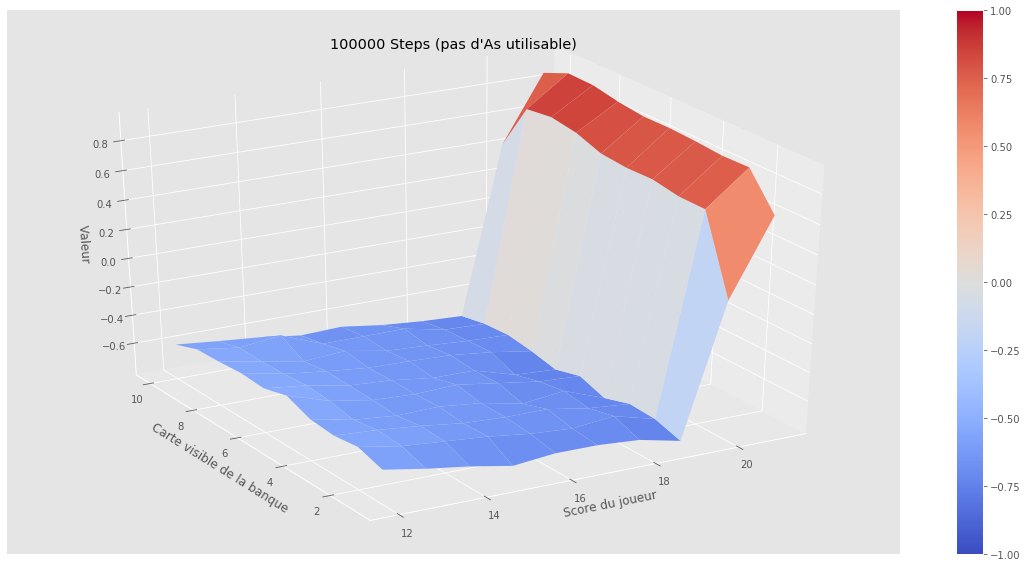

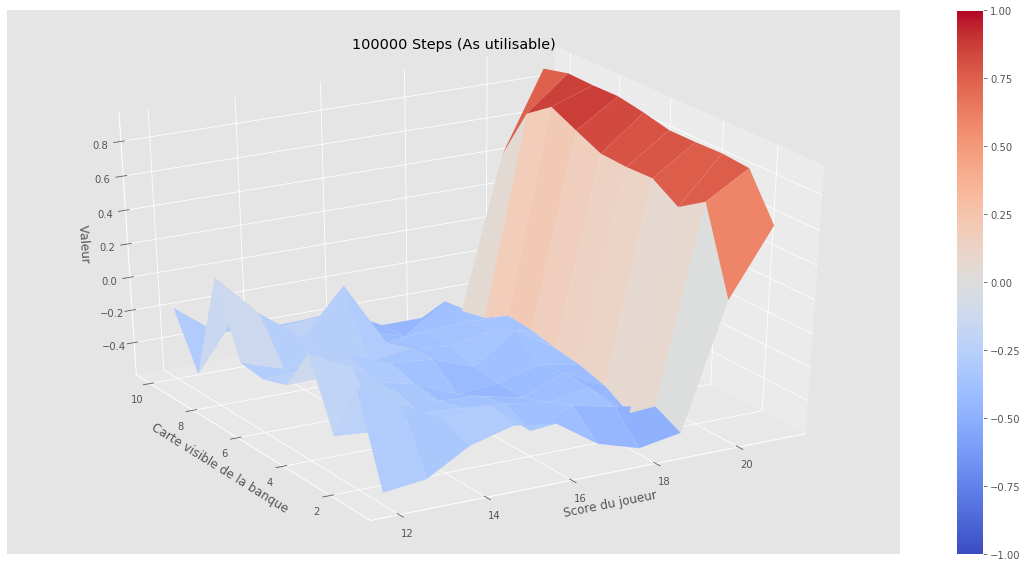

Episode 120000/200000.

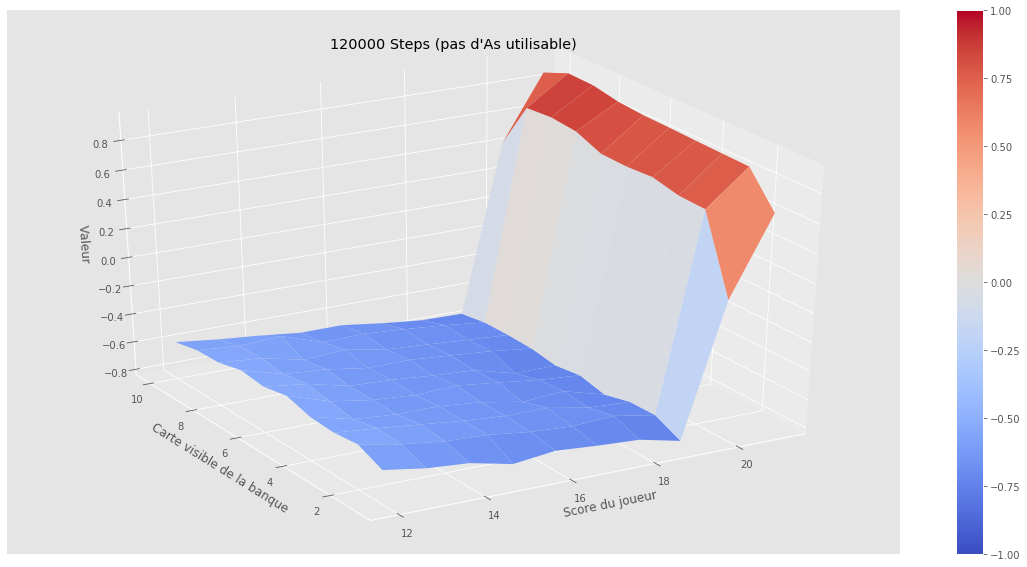

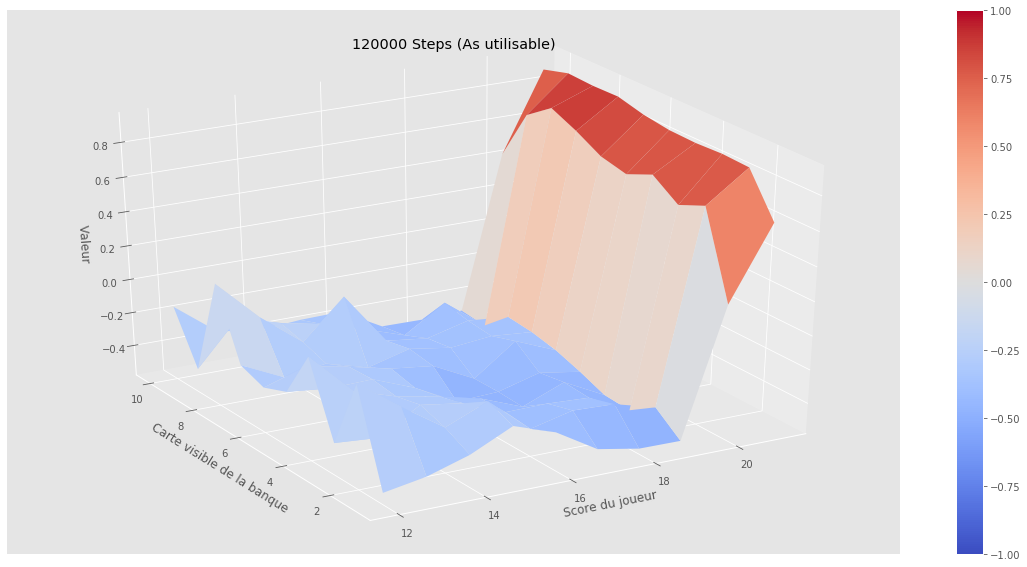

Episode 140000/200000.

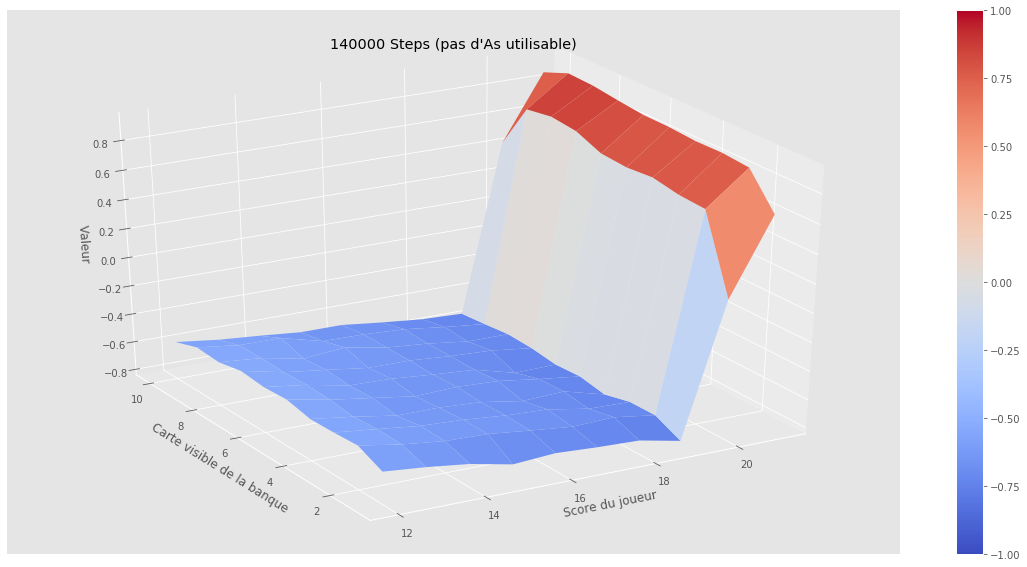

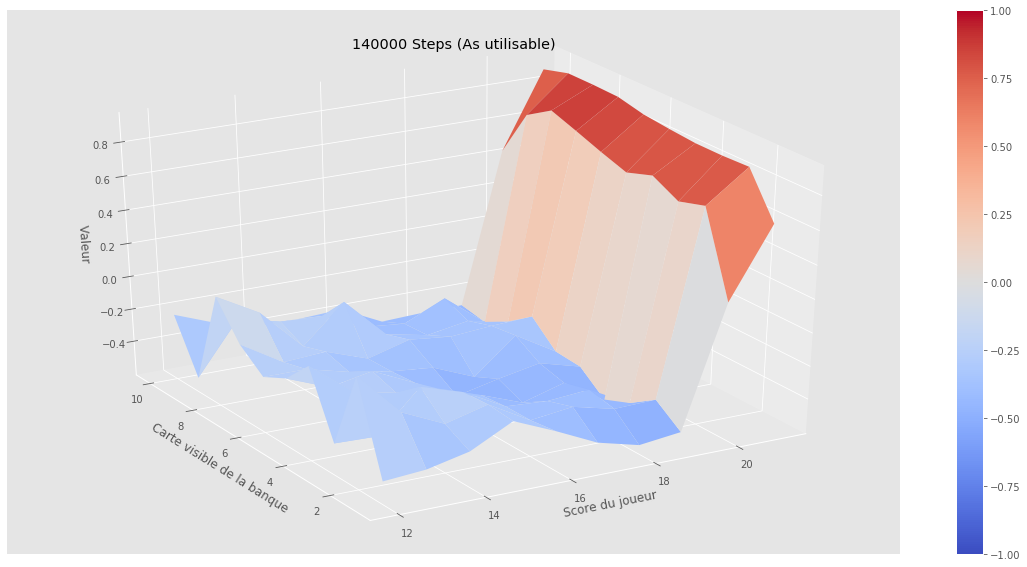

Episode 160000/200000.

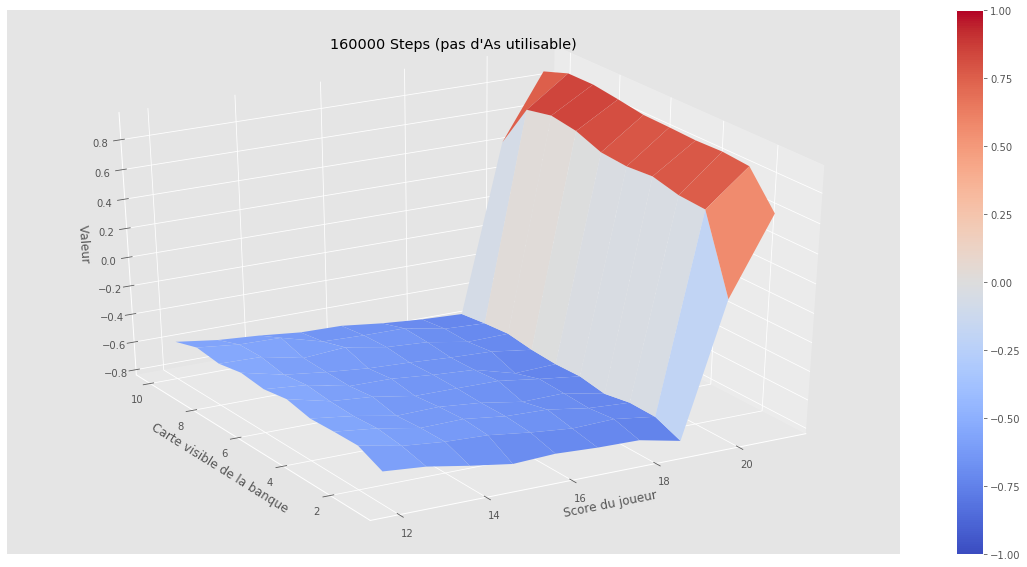

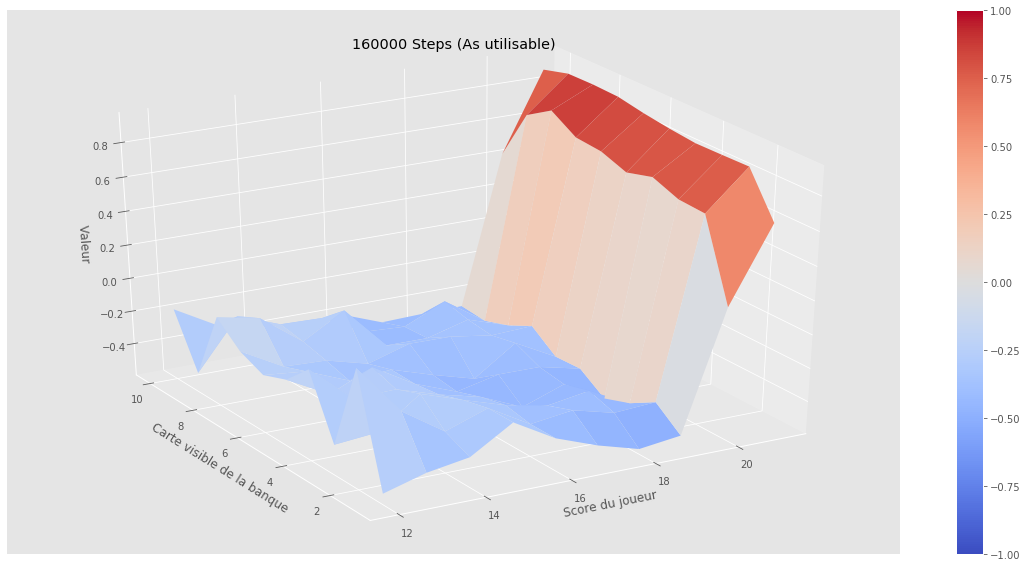

Episode 180000/200000.

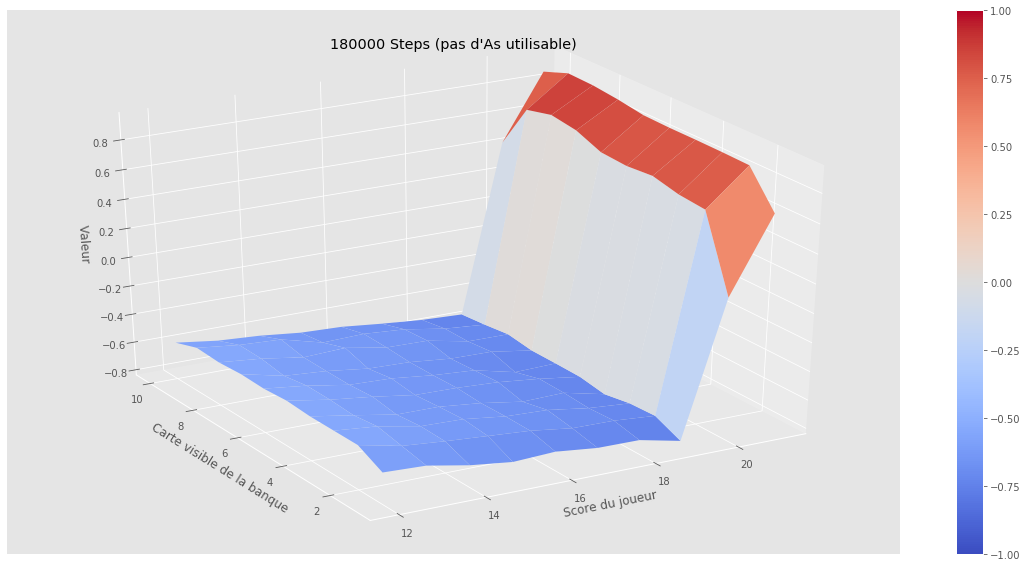

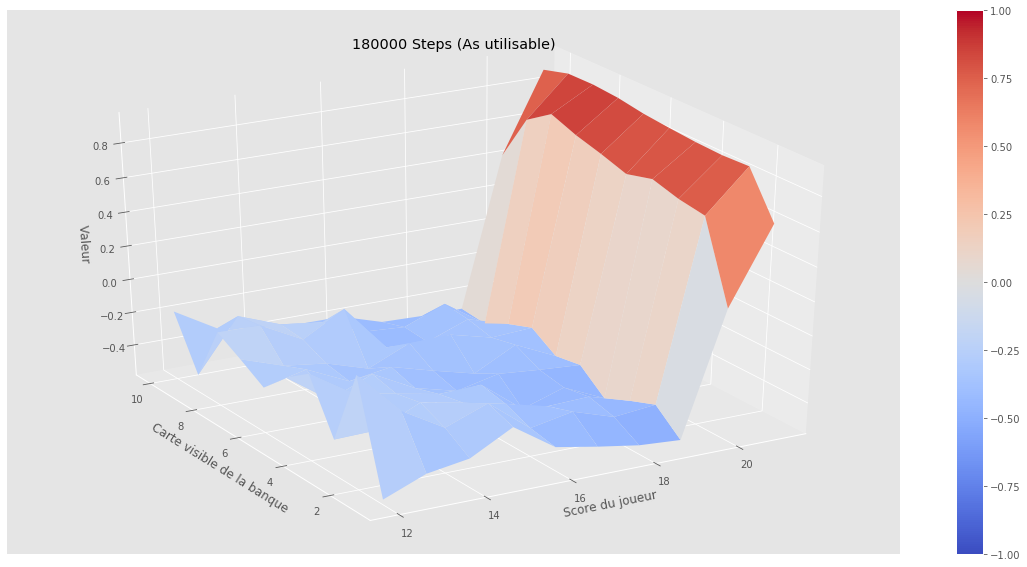

Episode 200000/200000.

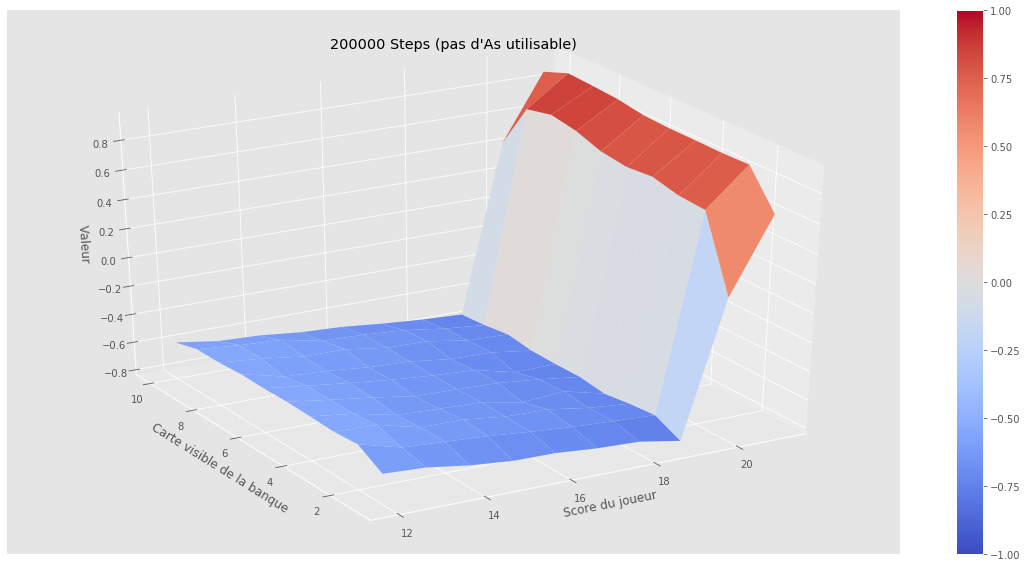

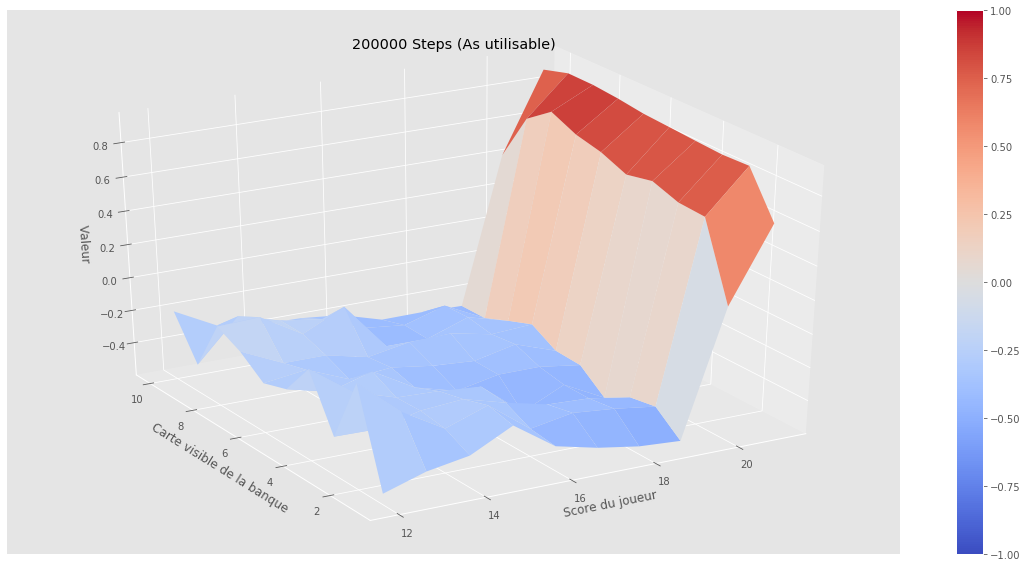

In [7]:
V_20k = mc_prediction(sample_policy, env, num_episodes=200000, plot_every=20000)

**Réponse:** Un plus grand nombre d'épisodes nous offre une meilleure estimation de la fonction de valeur. 

Dans ce cas, la fonction de valeur devient de plus en plus lisse avec plus d'épisodes. On peut voir que la fonction de valeur pour les états sans As utilisable (`pas d'As utilisable`) semble converger plus rapidement. C'est sans doute parce que la variance de leurs récompenses est plus petite. 

## 2. Monte Carlo control

Maintenant, nous nous tournons vers **l'algorithme Monte Carlo (on policy) control**.

L'algorithme est donné à la diapo 22 (Monte Carlo on-policy).

Nous allons aussi tester la capacité de l'algorithme à trouver une politique optimale pour le jeu du Blackjack (diapo supplémentaire #32)

### 2.1 Politique $\epsilon$-greedy

Revoyons d'abord le principe des politique $\epsilon$-greedy policy. 

C'est une politique qui prend l'action prescrite avec une probabilité de $1-\epsilon$ et une action aléatoire avec une probabilité $\epsilon$. Par action prescrite on entend celle avec la plus grande valeur ($Q(s,a)$), par exemple. On imagine que $\epsilon$ est petit (par exemple 5%). 

C'est une façon de s'assurer que la politique continue à explorer le monde et donc à trouver un équilibre entre l'exploitation est l'exploration (on peut imaginer que la valeur de $\epsilon$ peut aussi diminuer avec le temps.)

(On en discute à la diapo 19).

In [8]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Cré une politique epsilon-greedy en fonction d'une fonction Q et d'un epsilon
    
    Args:
        Q: Un dictionnaire d'état -> valeur d'actions.
            Chaque valeur pointe vers un vecteur de valeurs. Chaque dimension 
            de ce vecteur correspond à une action.
        epsilon: La probabilité (entre 0 et 1) de sélectionner une action aléatoire.
        nA: Le nombre d'actions dans l'environnement.
    
    Returns:
        Une politique \epsilon-greedy. C'est-à-dire une fonction qui prendre en argument 
        un état et retourne la probabilité de toutes les actions. 
    
    """
    assert epsilon >0 and epsilon <1
    def policy_fn(state):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[state])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### 2.2 Algorithme Monte Carlo control

Ci-dessous nous avons implémenté l'algorithme Monte Carlo Control.

Il prend en paramètres&nbsp;: l'environnement (`env`), le nombre d'épisodes à essayer (`num_episodes`), le facteur d'atténuation (`discount_factor`) et la valeur de $\epsilon$.

Rappel: l'algorithme trouve la fonction de valeur optimale $Q^*(s,a)$ pour chaque pair $(a,s)$. À partir de cette fonction on peut obtenir la politique optimale $\pi^*$: 
$$
\pi^*(s) = \arg\max_a Q^*(s,a)\;\;\;\;\;\;\;\; \forall s \in S
$$


In [9]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, 
                              epsilon=0.1, plot_every=False):
    """
    Monte Carlo Control utilisant une politique epsilon-Greedy.
    Trouve la meilleure politique epsilon-greedy.
    
    Args:
        env: Un environnemnt OpenAI gym.
        num_episodes: Le nombres d'épisodes
        discount_factor: Gamma le facteur d'actualisation.
        epsilon: La probabilité d'exécuter une action aléatoire (entre 0 et 1).
    
    Returns:
        A tuple (Q, policy).
        Q une dictionnaire d'un état -> valeur des actions.
        la politique est une fonction qui prend un état en entrée 
        et retourne une distribution sur les actions. 
    """
    
    # Pour garder les récompenses ainsi que le nombre 
    # de fois que l'agent a visité chaque état.
    # On poura utiliser cette information pour obtenir la moyenne
    # moyenne = returns_sum / returns_count
    # (note technique: on utilise un dictionnaire, on aurait
    # aussi pu utiliser un vecteur pour conserver ces informations.)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # La fonction de valeur Q(s,a)
    # par défaut elle est initialisée à 0 pour toutes les actions.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # La politique actuelle
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # On affiche le numéro de l'épisode
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # On génère un épisode.
        # An épisode est un vecteur de tuples (état, action, récompense)
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Pour chaque paire (état, action) dans l'épisode,
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # On trouve la première occurrence du tuple (état, action)
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # On calcule la somme des toutes les récompenses
            G = sum([x[2]*(discount_factor**i) 
                     for i,x in enumerate(episode[first_occurence_idx:])])
            # On calcule le retour moyen pour cet état sur tous les épisodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0

            # mise à jour de la fonction de valeur
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
  
        # on affiche la fonction de valeur
        if plot_every and i_episode % plot_every==0:
            V = defaultdict(float)
            for state, actions in Q.items():
                action_value = np.max(actions)
                V[state] = action_value
            plotting.plot_value_function(V, 
                                         title=
                                         f"Fonction de valeur à l'itération {i_episode}")

    
    return Q, policy

On l'entraîne pour 100k épisodes (échantillons).

In [11]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=1000000, epsilon=0.025)

Episode 1000000/1000000.

Nous pouvons inspecter la fonction de valeur résultante. Cette figure ressemble à celle de la diapo 16. 

Pour chaque état nous utilisons la valeur de la meilleure action: 
$$
\max_a Q(s,a)
$$

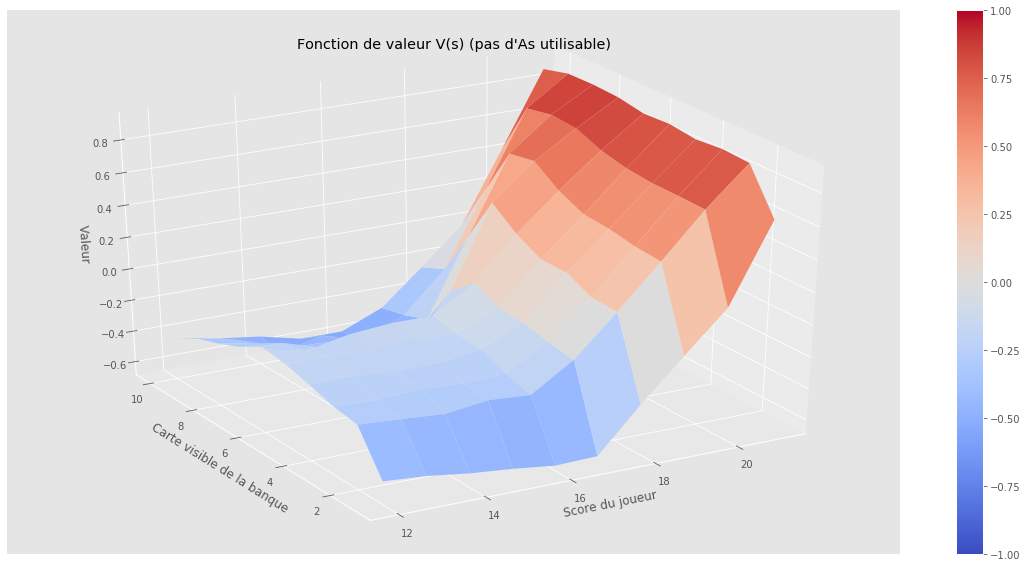

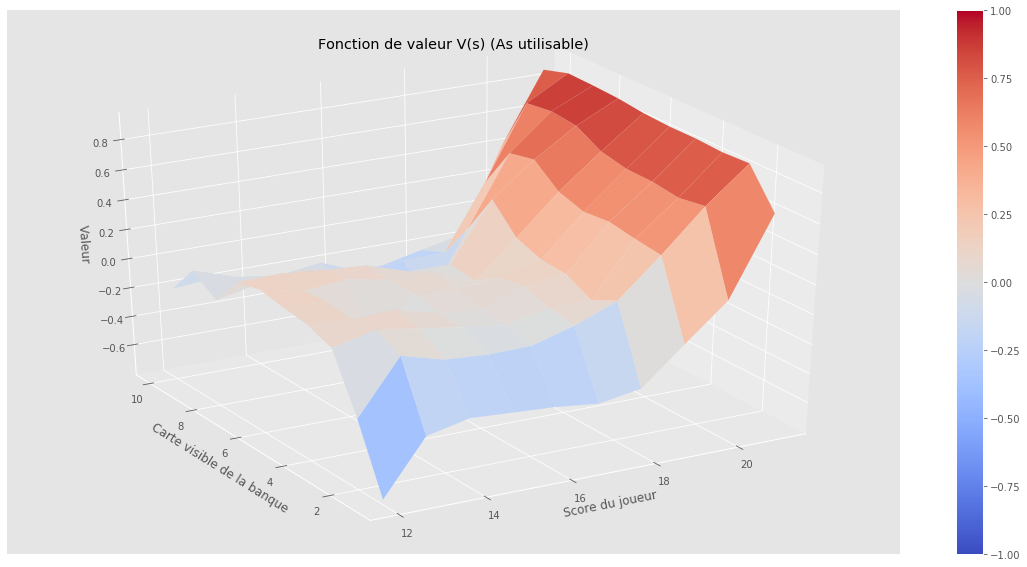

In [12]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Fonction de valeur V(s)")

**Question :** Comment cette fonction se compare-t-elle à celle de la politique simple évaluée à la Section 1.2?

**Réponse possible :** 
- Comme maintenant nous optimisons la politique, la valeur de la politique optimale devrait être au moins aussi bonne que la valeur de la politique simple. 
- La valeur de cette politique semble aussi beaucoup plus lisse, même sans As utilisable. 
- On voit que la valeur augmente clairement autour du score de 18. Même en deçà, la fonction de valeur est en haut de 0 sauf si la banque à un as ou une carte valant dix.

On peut aussi examiner la politique apprise. C'est la politique optimale si la procédure a convergé.

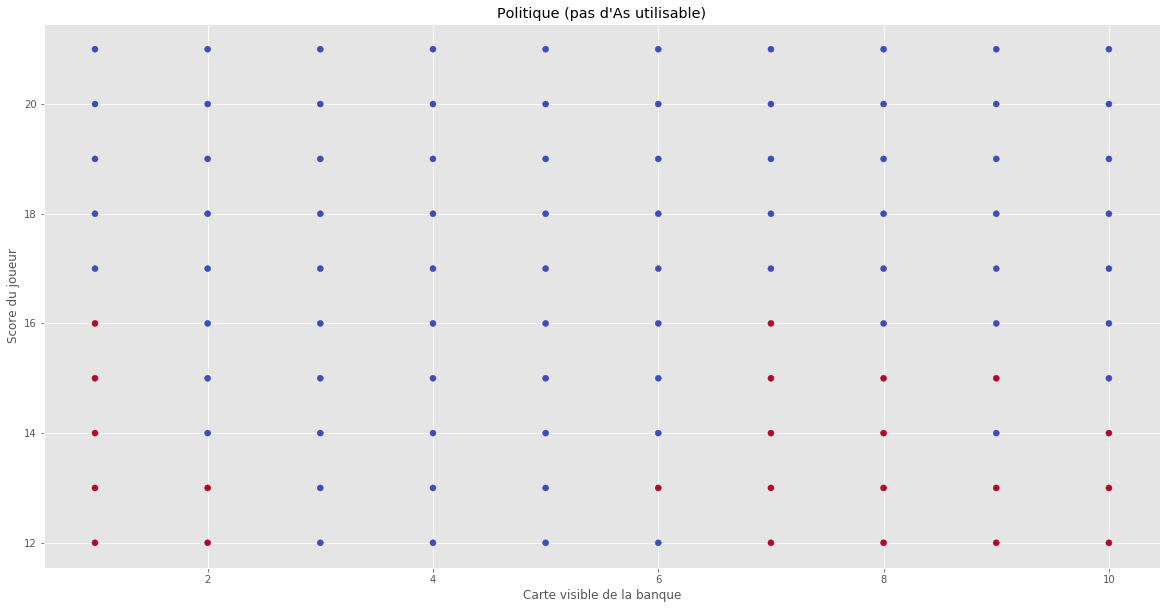

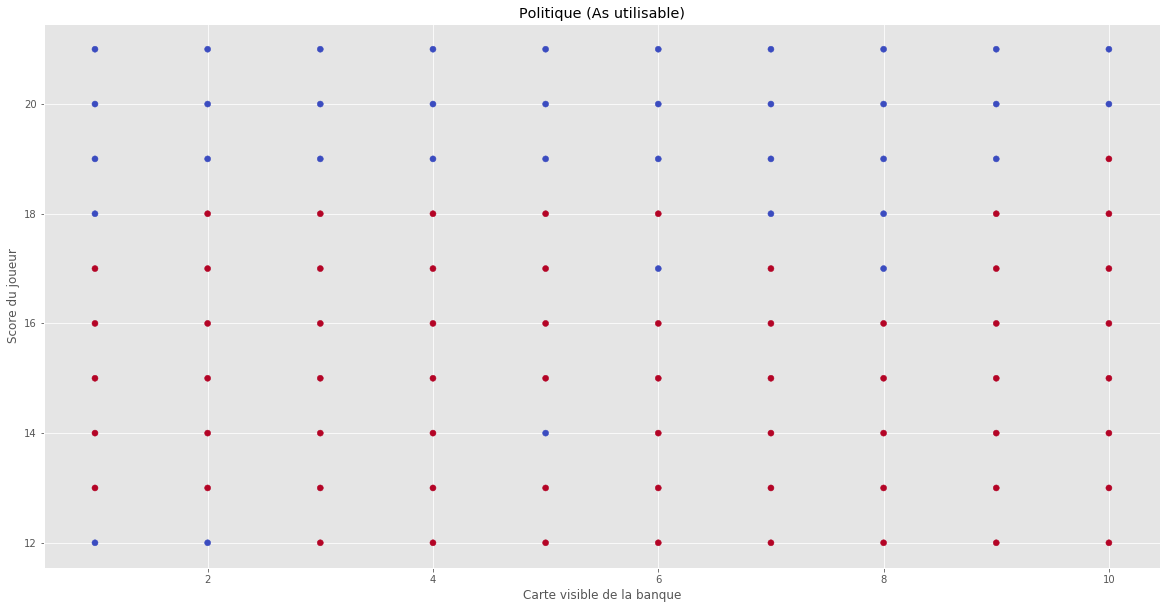

In [13]:
#sorted_keys = sort(Q.keys())
import collections 

V = defaultdict(str)
for state, actions in Q.items():
    action_id = np.argmax(actions)
    V[state] = action_id;

plotting.plot_policy(V, title="Politique")

#Qo = collections.OrderedDict(sorted(Q.items()))
#for state, actions in Qo.items():
#    if state[2]:
#        action_value = np.argmax(actions)
#        #print(state[0], state[1], action_value)
#
#
#for state, actions in Qo.items():
#    if not state[2] :
#        action_value = np.argmax(actions)
#        #print(state[0], state[1], action_value)

On peut comparer avec la politique optimale donnée dans le livre de Reinforcement Learning de Barto et Sutton.

La politique que nous avons apprise est une politique $\epsilon$-greedy. Il est donc possible qu'elle soit moins bonne que la politique apprise avec les exploring starts (ES). 

<img src="MC_control_ES_Sutton.png">